In [3]:
!pip install tensorflow_addons

  Using cached tensorflow_addons-0.20.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (591 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)


In [4]:
#Imports and settings

import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import sys

import tensorflow as tf
from tqdm.notebook import tqdm
import tensorflow_addons as tfa


from sklearn.model_selection import train_test_split

np.set_printoptions(suppress=True)

/opt/conda/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/opt/conda/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're usin

In [21]:
# load the features and labels (subtract 1 as the labels aren't indexed from 0)
ytest = np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/test/y_test.txt')-1
ytrain = np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/train/y_train.txt')-1

In [22]:
# load the x,y,z body accelerations test data
xx_test=np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/test/Inertial Signals/body_acc_x_test.txt')
yy_test=np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/test/Inertial Signals/body_acc_y_test.txt')
zz_test=np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/test/Inertial Signals/body_acc_z_test.txt')
# concatenate the arrays along the last dimension
xtest = np.concatenate((xx_test[:,:,None],yy_test[:,:,None],zz_test[:,:,None]),axis=2)
# (using None here adds an extra dimension of size 1 to the end of the array)

In [23]:
# follow the same approach for the train data
xx_train=np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/train/Inertial Signals/body_acc_x_train.txt')
yy_train=np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/train/Inertial Signals/body_acc_y_train.txt')
zz_train=np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/train/Inertial Signals/body_acc_z_train.txt')
xtrain = np.concatenate((xx_train[:,:,None],yy_train[:,:,None],zz_train[:,:,None]),axis=2)

In [24]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(7352, 128, 3)
(2947, 128, 3)
(7352,)
(2947,)


## Part 2
### 1‐dimensional convolutional neural network
Note: Your training data tensors will need to have their original shape of [n,128,3] so make sure to recreate the tensors after
you have completed part 1

In [37]:
#tensorboad set up
logdir = '/home/jovyan/logs/Project/Part2'

In [100]:
#Recreate the tensors
x_input, x_val, y_input, y_val = train_test_split(xtrain, ytrain, test_size=0.2, random_state=10)

#one-hot encoding for labels
y_input = tf.keras.utils.to_categorical(y_input)
y_val = tf.keras.utils.to_categorical(y_val)

print(xtrain.shape)
print(xtest.shape)
print(y_input.shape)
print(y_val.shape)

(7352, 128, 3)
(2947, 128, 3)
(5881, 6)
(1471, 6)


In [101]:
# Convert your input and validation data to a tensor so that you can pass it into your classifier
x_input = tf.convert_to_tensor(x_input, tf.float32)
x_val = tf.convert_to_tensor(x_val, tf.float32)
y_input = tf.convert_to_tensor(y_input, tf.float32)
y_val = tf.convert_to_tensor(y_val, tf.float32)

In [102]:
# Keras API model

#We create the input layer and combine with further dense layers,
input_layer = tf.keras.Input(shape=(128, 3))
output_layer = tf.keras.layers.Conv1D(filters=128, kernel_size=16)(input_layer)
output_layer = tf.keras.layers.BatchNormalization()(output_layer)
output_layer = tf.keras.layers.Dense(64, activation='relu')(output_layer)
output_layer = tf.keras.layers.GlobalAveragePooling1D()(output_layer)

# # Add a softmax layer with  output units:
output_layer = tf.keras.layers.Dense(6, activation='softmax')(output_layer)


In [103]:
# Compile model

# Callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
# create a callback that will stop training if the validation loss hasn't improved for 2 epochs
early_stopping_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)]
# initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar()

model = tf.keras.Model(inputs=input_layer,outputs=output_layer)

#The compilation and training then proceeds as per the sequential model,
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 128, 3)]          0         
                                                                 
 conv1d_17 (Conv1D)          (None, 113, 128)          6272      
                                                                 
 batch_normalization_17 (Bat  (None, 113, 128)         512       
 chNormalization)                                                
                                                                 
 dense_34 (Dense)            (None, 113, 64)           8256      
                                                                 
 global_average_pooling1d_17  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_35 (Dense)            (None, 6)                 390

In [104]:
model.fit(x_input, y_input, 
          epochs=200, 
          batch_size=128,
          validation_data=(x_val, y_val),
          callbacks=[tensorboard_callback, tqdm_callback]
         )

Training:   0%|           0/200 ETA: ?s,  ?epochs/s

Epoch 1/200


0/46           ETA: ?s - 

Epoch 1/200
46/46 [==============================] - 1s 8ms/step - loss: 1.2814 - accuracy: 0.5031 - val_loss: 1.6858 - val_accuracy: 0.1924
Epoch 2/200


0/46           ETA: ?s - 

Epoch 2/200
46/46 [==============================] - 0s 5ms/step - loss: 0.8802 - accuracy: 0.6308 - val_loss: 1.9450 - val_accuracy: 0.1835
Epoch 3/200


0/46           ETA: ?s - 

Epoch 3/200
46/46 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.7011 - val_loss: 2.2462 - val_accuracy: 0.2325
Epoch 4/200


0/46           ETA: ?s - 

Epoch 4/200
46/46 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.7466 - val_loss: 2.1856 - val_accuracy: 0.2305
Epoch 5/200


0/46           ETA: ?s - 

Epoch 5/200
46/46 [==============================] - 0s 4ms/step - loss: 0.5898 - accuracy: 0.7647 - val_loss: 1.9313 - val_accuracy: 0.2223
Epoch 6/200


0/46           ETA: ?s - 

Epoch 6/200
46/46 [==============================] - 0s 4ms/step - loss: 0.5611 - accuracy: 0.7795 - val_loss: 1.5735 - val_accuracy: 0.3256
Epoch 7/200


0/46           ETA: ?s - 

Epoch 7/200
46/46 [==============================] - 0s 4ms/step - loss: 0.5375 - accuracy: 0.7875 - val_loss: 1.1451 - val_accuracy: 0.5071
Epoch 8/200


0/46           ETA: ?s - 

Epoch 8/200
46/46 [==============================] - 0s 4ms/step - loss: 0.5216 - accuracy: 0.7939 - val_loss: 0.8308 - val_accuracy: 0.7036
Epoch 9/200


0/46           ETA: ?s - 

Epoch 9/200
46/46 [==============================] - 0s 4ms/step - loss: 0.5101 - accuracy: 0.7965 - val_loss: 0.6518 - val_accuracy: 0.7913
Epoch 10/200


0/46           ETA: ?s - 

Epoch 10/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4934 - accuracy: 0.8192 - val_loss: 0.5556 - val_accuracy: 0.7675
Epoch 11/200


0/46           ETA: ?s - 

Epoch 11/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4856 - accuracy: 0.8114 - val_loss: 0.5102 - val_accuracy: 0.7974
Epoch 12/200


0/46           ETA: ?s - 

Epoch 12/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4772 - accuracy: 0.8150 - val_loss: 0.4875 - val_accuracy: 0.8436
Epoch 13/200


0/46           ETA: ?s - 

Epoch 13/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4692 - accuracy: 0.8160 - val_loss: 0.4705 - val_accuracy: 0.8443
Epoch 14/200


0/46           ETA: ?s - 

Epoch 14/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4616 - accuracy: 0.8266 - val_loss: 0.4615 - val_accuracy: 0.8015
Epoch 15/200


0/46           ETA: ?s - 

Epoch 15/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4605 - accuracy: 0.8114 - val_loss: 0.4488 - val_accuracy: 0.8341
Epoch 16/200


0/46           ETA: ?s - 

Epoch 16/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4559 - accuracy: 0.8135 - val_loss: 0.4409 - val_accuracy: 0.8328
Epoch 17/200


0/46           ETA: ?s - 

Epoch 17/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4541 - accuracy: 0.8085 - val_loss: 0.4401 - val_accuracy: 0.8545
Epoch 18/200


0/46           ETA: ?s - 

Epoch 18/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4496 - accuracy: 0.8157 - val_loss: 0.4324 - val_accuracy: 0.8375
Epoch 19/200


0/46           ETA: ?s - 

Epoch 19/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4355 - accuracy: 0.8322 - val_loss: 0.4179 - val_accuracy: 0.8634
Epoch 20/200


0/46           ETA: ?s - 

Epoch 20/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4345 - accuracy: 0.8318 - val_loss: 0.4229 - val_accuracy: 0.8416
Epoch 21/200


0/46           ETA: ?s - 

Epoch 21/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4286 - accuracy: 0.8329 - val_loss: 0.4170 - val_accuracy: 0.8287
Epoch 22/200


0/46           ETA: ?s - 

Epoch 22/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4264 - accuracy: 0.8327 - val_loss: 0.4213 - val_accuracy: 0.8144
Epoch 23/200


0/46           ETA: ?s - 

Epoch 23/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4276 - accuracy: 0.8233 - val_loss: 0.4068 - val_accuracy: 0.8600
Epoch 24/200


0/46           ETA: ?s - 

Epoch 24/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4242 - accuracy: 0.8266 - val_loss: 0.4050 - val_accuracy: 0.8457
Epoch 25/200


0/46           ETA: ?s - 

Epoch 25/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4184 - accuracy: 0.8395 - val_loss: 0.3980 - val_accuracy: 0.8538
Epoch 26/200


0/46           ETA: ?s - 

Epoch 26/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4103 - accuracy: 0.8364 - val_loss: 0.4019 - val_accuracy: 0.8545
Epoch 27/200


0/46           ETA: ?s - 

Epoch 27/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4231 - accuracy: 0.8206 - val_loss: 0.4225 - val_accuracy: 0.7913
Epoch 28/200


0/46           ETA: ?s - 

Epoch 28/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4139 - accuracy: 0.8369 - val_loss: 0.3958 - val_accuracy: 0.8552
Epoch 29/200


0/46           ETA: ?s - 

Epoch 29/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4101 - accuracy: 0.8300 - val_loss: 0.3972 - val_accuracy: 0.8307
Epoch 30/200


0/46           ETA: ?s - 

Epoch 30/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4057 - accuracy: 0.8390 - val_loss: 0.3909 - val_accuracy: 0.8538
Epoch 31/200


0/46           ETA: ?s - 

Epoch 31/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4034 - accuracy: 0.8402 - val_loss: 0.3951 - val_accuracy: 0.8368
Epoch 32/200


0/46           ETA: ?s - 

Epoch 32/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4010 - accuracy: 0.8374 - val_loss: 0.3954 - val_accuracy: 0.8402
Epoch 33/200


0/46           ETA: ?s - 

Epoch 33/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4006 - accuracy: 0.8475 - val_loss: 0.3859 - val_accuracy: 0.8593
Epoch 34/200


0/46           ETA: ?s - 

Epoch 34/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3934 - accuracy: 0.8527 - val_loss: 0.3834 - val_accuracy: 0.8640
Epoch 35/200


0/46           ETA: ?s - 

Epoch 35/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3937 - accuracy: 0.8482 - val_loss: 0.3778 - val_accuracy: 0.8688
Epoch 36/200


0/46           ETA: ?s - 

Epoch 36/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3877 - accuracy: 0.8493 - val_loss: 0.3870 - val_accuracy: 0.8443
Epoch 37/200


0/46           ETA: ?s - 

Epoch 37/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3923 - accuracy: 0.8407 - val_loss: 0.3848 - val_accuracy: 0.8640
Epoch 38/200


0/46           ETA: ?s - 

Epoch 38/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3943 - accuracy: 0.8466 - val_loss: 0.3719 - val_accuracy: 0.8770
Epoch 39/200


0/46           ETA: ?s - 

Epoch 39/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3831 - accuracy: 0.8487 - val_loss: 0.3741 - val_accuracy: 0.8586
Epoch 40/200


0/46           ETA: ?s - 

Epoch 40/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3792 - accuracy: 0.8485 - val_loss: 0.3691 - val_accuracy: 0.8756
Epoch 41/200


0/46           ETA: ?s - 

Epoch 41/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3850 - accuracy: 0.8478 - val_loss: 0.3817 - val_accuracy: 0.8708
Epoch 42/200


0/46           ETA: ?s - 

Epoch 42/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3841 - accuracy: 0.8480 - val_loss: 0.3692 - val_accuracy: 0.8715
Epoch 43/200


0/46           ETA: ?s - 

Epoch 43/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3814 - accuracy: 0.8451 - val_loss: 0.3802 - val_accuracy: 0.8518
Epoch 44/200


0/46           ETA: ?s - 

Epoch 44/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3781 - accuracy: 0.8543 - val_loss: 0.3684 - val_accuracy: 0.8695
Epoch 45/200


0/46           ETA: ?s - 

Epoch 45/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3803 - accuracy: 0.8456 - val_loss: 0.3685 - val_accuracy: 0.8498
Epoch 46/200


0/46           ETA: ?s - 

Epoch 46/200
46/46 [==============================] - 0s 5ms/step - loss: 0.3765 - accuracy: 0.8470 - val_loss: 0.3776 - val_accuracy: 0.8674
Epoch 47/200


0/46           ETA: ?s - 

Epoch 47/200
46/46 [==============================] - 0s 5ms/step - loss: 0.3738 - accuracy: 0.8565 - val_loss: 0.3908 - val_accuracy: 0.8586
Epoch 48/200


0/46           ETA: ?s - 

Epoch 48/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3779 - accuracy: 0.8482 - val_loss: 0.3793 - val_accuracy: 0.8620
Epoch 49/200


0/46           ETA: ?s - 

Epoch 49/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3802 - accuracy: 0.8517 - val_loss: 0.3746 - val_accuracy: 0.8756
Epoch 50/200


0/46           ETA: ?s - 

Epoch 50/200
46/46 [==============================] - 0s 5ms/step - loss: 0.3746 - accuracy: 0.8439 - val_loss: 0.3658 - val_accuracy: 0.8797
Epoch 51/200


0/46           ETA: ?s - 

Epoch 51/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3769 - accuracy: 0.8500 - val_loss: 0.3672 - val_accuracy: 0.8566
Epoch 52/200


0/46           ETA: ?s - 

Epoch 52/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3748 - accuracy: 0.8458 - val_loss: 0.3694 - val_accuracy: 0.8654
Epoch 53/200


0/46           ETA: ?s - 

Epoch 53/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3691 - accuracy: 0.8539 - val_loss: 0.3727 - val_accuracy: 0.8729
Epoch 54/200


0/46           ETA: ?s - 

Epoch 54/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3676 - accuracy: 0.8565 - val_loss: 0.3670 - val_accuracy: 0.8627
Epoch 55/200


0/46           ETA: ?s - 

Epoch 55/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3676 - accuracy: 0.8521 - val_loss: 0.3548 - val_accuracy: 0.8708
Epoch 56/200


0/46           ETA: ?s - 

Epoch 56/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3645 - accuracy: 0.8548 - val_loss: 0.3702 - val_accuracy: 0.8695
Epoch 57/200


0/46           ETA: ?s - 

Epoch 57/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3664 - accuracy: 0.8526 - val_loss: 0.3705 - val_accuracy: 0.8545
Epoch 58/200


0/46           ETA: ?s - 

Epoch 58/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3611 - accuracy: 0.8595 - val_loss: 0.3504 - val_accuracy: 0.8756
Epoch 59/200


0/46           ETA: ?s - 

Epoch 59/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3700 - accuracy: 0.8482 - val_loss: 0.3658 - val_accuracy: 0.8464
Epoch 60/200


0/46           ETA: ?s - 

Epoch 60/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3590 - accuracy: 0.8592 - val_loss: 0.3457 - val_accuracy: 0.8736
Epoch 61/200


0/46           ETA: ?s - 

Epoch 61/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3627 - accuracy: 0.8567 - val_loss: 0.3553 - val_accuracy: 0.8498
Epoch 62/200


0/46           ETA: ?s - 

Epoch 62/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3610 - accuracy: 0.8570 - val_loss: 0.3471 - val_accuracy: 0.8749
Epoch 63/200


0/46           ETA: ?s - 

Epoch 63/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3573 - accuracy: 0.8546 - val_loss: 0.3692 - val_accuracy: 0.8423
Epoch 64/200


0/46           ETA: ?s - 

Epoch 64/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3630 - accuracy: 0.8497 - val_loss: 0.3568 - val_accuracy: 0.8736
Epoch 65/200


0/46           ETA: ?s - 

Epoch 65/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3608 - accuracy: 0.8550 - val_loss: 0.3449 - val_accuracy: 0.8865
Epoch 66/200


0/46           ETA: ?s - 

Epoch 66/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3585 - accuracy: 0.8604 - val_loss: 0.3504 - val_accuracy: 0.8729
Epoch 67/200


0/46           ETA: ?s - 

Epoch 67/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3619 - accuracy: 0.8563 - val_loss: 0.3483 - val_accuracy: 0.8763
Epoch 68/200


0/46           ETA: ?s - 

Epoch 68/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3510 - accuracy: 0.8567 - val_loss: 0.3567 - val_accuracy: 0.8695
Epoch 69/200


0/46           ETA: ?s - 

Epoch 69/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3632 - accuracy: 0.8531 - val_loss: 0.3546 - val_accuracy: 0.8586
Epoch 70/200


0/46           ETA: ?s - 

Epoch 70/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3567 - accuracy: 0.8551 - val_loss: 0.3392 - val_accuracy: 0.8776
Epoch 71/200


0/46           ETA: ?s - 

Epoch 71/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3542 - accuracy: 0.8563 - val_loss: 0.3472 - val_accuracy: 0.8824
Epoch 72/200


0/46           ETA: ?s - 

Epoch 72/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3567 - accuracy: 0.8519 - val_loss: 0.3490 - val_accuracy: 0.8654
Epoch 73/200


0/46           ETA: ?s - 

Epoch 73/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3444 - accuracy: 0.8641 - val_loss: 0.3318 - val_accuracy: 0.8831
Epoch 74/200


0/46           ETA: ?s - 

Epoch 74/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3531 - accuracy: 0.8584 - val_loss: 0.3374 - val_accuracy: 0.8742
Epoch 75/200


0/46           ETA: ?s - 

Epoch 75/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3545 - accuracy: 0.8555 - val_loss: 0.3493 - val_accuracy: 0.8538
Epoch 76/200


0/46           ETA: ?s - 

Epoch 76/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3538 - accuracy: 0.8551 - val_loss: 0.3364 - val_accuracy: 0.8756
Epoch 77/200


0/46           ETA: ?s - 

Epoch 77/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3508 - accuracy: 0.8612 - val_loss: 0.3311 - val_accuracy: 0.8824
Epoch 78/200


0/46           ETA: ?s - 

Epoch 78/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3468 - accuracy: 0.8618 - val_loss: 0.3454 - val_accuracy: 0.8756
Epoch 79/200


0/46           ETA: ?s - 

Epoch 79/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3525 - accuracy: 0.8555 - val_loss: 0.3348 - val_accuracy: 0.8810
Epoch 80/200


0/46           ETA: ?s - 

Epoch 80/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3549 - accuracy: 0.8623 - val_loss: 0.3344 - val_accuracy: 0.8844
Epoch 81/200


0/46           ETA: ?s - 

Epoch 81/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3556 - accuracy: 0.8512 - val_loss: 0.3368 - val_accuracy: 0.8858
Epoch 82/200


0/46           ETA: ?s - 

Epoch 82/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3604 - accuracy: 0.8463 - val_loss: 0.3580 - val_accuracy: 0.8600
Epoch 83/200


0/46           ETA: ?s - 

Epoch 83/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3434 - accuracy: 0.8612 - val_loss: 0.3487 - val_accuracy: 0.8770
Epoch 84/200


0/46           ETA: ?s - 

Epoch 84/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3431 - accuracy: 0.8652 - val_loss: 0.3467 - val_accuracy: 0.8763
Epoch 85/200


0/46           ETA: ?s - 

Epoch 85/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3517 - accuracy: 0.8607 - val_loss: 0.3411 - val_accuracy: 0.8647
Epoch 86/200


0/46           ETA: ?s - 

Epoch 86/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3533 - accuracy: 0.8561 - val_loss: 0.3436 - val_accuracy: 0.8797
Epoch 87/200


0/46           ETA: ?s - 

Epoch 87/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3477 - accuracy: 0.8609 - val_loss: 0.3404 - val_accuracy: 0.8715
Epoch 88/200


0/46           ETA: ?s - 

Epoch 88/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3432 - accuracy: 0.8646 - val_loss: 0.3464 - val_accuracy: 0.8749
Epoch 89/200


0/46           ETA: ?s - 

Epoch 89/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3420 - accuracy: 0.8590 - val_loss: 0.3319 - val_accuracy: 0.8797
Epoch 90/200


0/46           ETA: ?s - 

Epoch 90/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3377 - accuracy: 0.8636 - val_loss: 0.3361 - val_accuracy: 0.8865
Epoch 91/200


0/46           ETA: ?s - 

Epoch 91/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3360 - accuracy: 0.8640 - val_loss: 0.3303 - val_accuracy: 0.8817
Epoch 92/200


0/46           ETA: ?s - 

Epoch 92/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3372 - accuracy: 0.8657 - val_loss: 0.3299 - val_accuracy: 0.8851
Epoch 93/200


0/46           ETA: ?s - 

Epoch 93/200
46/46 [==============================] - 0s 5ms/step - loss: 0.3386 - accuracy: 0.8607 - val_loss: 0.3343 - val_accuracy: 0.8804
Epoch 94/200


0/46           ETA: ?s - 

Epoch 94/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3341 - accuracy: 0.8699 - val_loss: 0.3447 - val_accuracy: 0.8668
Epoch 95/200


0/46           ETA: ?s - 

Epoch 95/200
46/46 [==============================] - 0s 5ms/step - loss: 0.3422 - accuracy: 0.8624 - val_loss: 0.3362 - val_accuracy: 0.8797
Epoch 96/200


0/46           ETA: ?s - 

Epoch 96/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3348 - accuracy: 0.8728 - val_loss: 0.3233 - val_accuracy: 0.8722
Epoch 97/200


0/46           ETA: ?s - 

Epoch 97/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3336 - accuracy: 0.8686 - val_loss: 0.3370 - val_accuracy: 0.8817
Epoch 98/200


0/46           ETA: ?s - 

Epoch 98/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3420 - accuracy: 0.8621 - val_loss: 0.3254 - val_accuracy: 0.8858
Epoch 99/200


0/46           ETA: ?s - 

Epoch 99/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3339 - accuracy: 0.8677 - val_loss: 0.3278 - val_accuracy: 0.8654
Epoch 100/200


0/46           ETA: ?s - 

Epoch 100/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3430 - accuracy: 0.8589 - val_loss: 0.3285 - val_accuracy: 0.8688
Epoch 101/200


0/46           ETA: ?s - 

Epoch 101/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3348 - accuracy: 0.8652 - val_loss: 0.3314 - val_accuracy: 0.8838
Epoch 102/200


0/46           ETA: ?s - 

Epoch 102/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3335 - accuracy: 0.8738 - val_loss: 0.3301 - val_accuracy: 0.8790
Epoch 103/200


0/46           ETA: ?s - 

Epoch 103/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3465 - accuracy: 0.8563 - val_loss: 0.3284 - val_accuracy: 0.8790
Epoch 104/200


0/46           ETA: ?s - 

Epoch 104/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3382 - accuracy: 0.8629 - val_loss: 0.3203 - val_accuracy: 0.8790
Epoch 105/200


0/46           ETA: ?s - 

Epoch 105/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3357 - accuracy: 0.8706 - val_loss: 0.3184 - val_accuracy: 0.8844
Epoch 106/200


0/46           ETA: ?s - 

Epoch 106/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3274 - accuracy: 0.8691 - val_loss: 0.3157 - val_accuracy: 0.8865
Epoch 107/200


0/46           ETA: ?s - 

Epoch 107/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3387 - accuracy: 0.8652 - val_loss: 0.3238 - val_accuracy: 0.8776
Epoch 108/200


0/46           ETA: ?s - 

Epoch 108/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3345 - accuracy: 0.8653 - val_loss: 0.3138 - val_accuracy: 0.8858
Epoch 109/200


0/46           ETA: ?s - 

Epoch 109/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3325 - accuracy: 0.8701 - val_loss: 0.3201 - val_accuracy: 0.8824
Epoch 110/200


0/46           ETA: ?s - 

Epoch 110/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3369 - accuracy: 0.8573 - val_loss: 0.3168 - val_accuracy: 0.8858
Epoch 111/200


0/46           ETA: ?s - 

Epoch 111/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3253 - accuracy: 0.8711 - val_loss: 0.3289 - val_accuracy: 0.8729
Epoch 112/200


0/46           ETA: ?s - 

Epoch 112/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3289 - accuracy: 0.8687 - val_loss: 0.3270 - val_accuracy: 0.8824
Epoch 113/200


0/46           ETA: ?s - 

Epoch 113/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3376 - accuracy: 0.8607 - val_loss: 0.3157 - val_accuracy: 0.8790
Epoch 114/200


0/46           ETA: ?s - 

Epoch 114/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3288 - accuracy: 0.8733 - val_loss: 0.3109 - val_accuracy: 0.8878
Epoch 115/200


0/46           ETA: ?s - 

Epoch 115/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3395 - accuracy: 0.8665 - val_loss: 0.3193 - val_accuracy: 0.8810
Epoch 116/200


0/46           ETA: ?s - 

Epoch 116/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3318 - accuracy: 0.8670 - val_loss: 0.3135 - val_accuracy: 0.8844
Epoch 117/200


0/46           ETA: ?s - 

Epoch 117/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3300 - accuracy: 0.8638 - val_loss: 0.3285 - val_accuracy: 0.8878
Epoch 118/200


0/46           ETA: ?s - 

Epoch 118/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3359 - accuracy: 0.8645 - val_loss: 0.3260 - val_accuracy: 0.8606
Epoch 119/200


0/46           ETA: ?s - 

Epoch 119/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3275 - accuracy: 0.8696 - val_loss: 0.3193 - val_accuracy: 0.8865
Epoch 120/200


0/46           ETA: ?s - 

Epoch 120/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3279 - accuracy: 0.8743 - val_loss: 0.3159 - val_accuracy: 0.8872
Epoch 121/200


0/46           ETA: ?s - 

Epoch 121/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3416 - accuracy: 0.8687 - val_loss: 0.3178 - val_accuracy: 0.8838
Epoch 122/200


0/46           ETA: ?s - 

Epoch 122/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3279 - accuracy: 0.8670 - val_loss: 0.3321 - val_accuracy: 0.8776
Epoch 123/200


0/46           ETA: ?s - 

Epoch 123/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3254 - accuracy: 0.8733 - val_loss: 0.3157 - val_accuracy: 0.8838
Epoch 124/200


0/46           ETA: ?s - 

Epoch 124/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3209 - accuracy: 0.8698 - val_loss: 0.3089 - val_accuracy: 0.8878
Epoch 125/200


0/46           ETA: ?s - 

Epoch 125/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3275 - accuracy: 0.8684 - val_loss: 0.3149 - val_accuracy: 0.8872
Epoch 126/200


0/46           ETA: ?s - 

Epoch 126/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3302 - accuracy: 0.8715 - val_loss: 0.3183 - val_accuracy: 0.8872
Epoch 127/200


0/46           ETA: ?s - 

Epoch 127/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3249 - accuracy: 0.8675 - val_loss: 0.3204 - val_accuracy: 0.8810
Epoch 128/200


0/46           ETA: ?s - 

Epoch 128/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3273 - accuracy: 0.8711 - val_loss: 0.3330 - val_accuracy: 0.8674
Epoch 129/200


0/46           ETA: ?s - 

Epoch 129/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3289 - accuracy: 0.8660 - val_loss: 0.3288 - val_accuracy: 0.8770
Epoch 130/200


0/46           ETA: ?s - 

Epoch 130/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3311 - accuracy: 0.8715 - val_loss: 0.3078 - val_accuracy: 0.8770
Epoch 131/200


0/46           ETA: ?s - 

Epoch 131/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3198 - accuracy: 0.8754 - val_loss: 0.3300 - val_accuracy: 0.8844
Epoch 132/200


0/46           ETA: ?s - 

Epoch 132/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3232 - accuracy: 0.8650 - val_loss: 0.3094 - val_accuracy: 0.8872
Epoch 133/200


0/46           ETA: ?s - 

Epoch 133/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3236 - accuracy: 0.8749 - val_loss: 0.3111 - val_accuracy: 0.8797
Epoch 134/200


0/46           ETA: ?s - 

Epoch 134/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3255 - accuracy: 0.8703 - val_loss: 0.3110 - val_accuracy: 0.8770
Epoch 135/200


0/46           ETA: ?s - 

Epoch 135/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3185 - accuracy: 0.8777 - val_loss: 0.3207 - val_accuracy: 0.8899
Epoch 136/200


0/46           ETA: ?s - 

Epoch 136/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3238 - accuracy: 0.8711 - val_loss: 0.3138 - val_accuracy: 0.8906
Epoch 137/200


0/46           ETA: ?s - 

Epoch 137/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3196 - accuracy: 0.8738 - val_loss: 0.3209 - val_accuracy: 0.8899
Epoch 138/200


0/46           ETA: ?s - 

Epoch 138/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3229 - accuracy: 0.8721 - val_loss: 0.3041 - val_accuracy: 0.8926
Epoch 139/200


0/46           ETA: ?s - 

Epoch 139/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3276 - accuracy: 0.8670 - val_loss: 0.3175 - val_accuracy: 0.8939
Epoch 140/200


0/46           ETA: ?s - 

Epoch 140/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3170 - accuracy: 0.8737 - val_loss: 0.3159 - val_accuracy: 0.8756
Epoch 141/200


0/46           ETA: ?s - 

Epoch 141/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3158 - accuracy: 0.8755 - val_loss: 0.3095 - val_accuracy: 0.8939
Epoch 142/200


0/46           ETA: ?s - 

Epoch 142/200
46/46 [==============================] - 0s 5ms/step - loss: 0.3146 - accuracy: 0.8764 - val_loss: 0.3142 - val_accuracy: 0.8810
Epoch 143/200


0/46           ETA: ?s - 

Epoch 143/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3233 - accuracy: 0.8670 - val_loss: 0.3154 - val_accuracy: 0.8797
Epoch 144/200


0/46           ETA: ?s - 

Epoch 144/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3185 - accuracy: 0.8691 - val_loss: 0.3114 - val_accuracy: 0.8885
Epoch 145/200


0/46           ETA: ?s - 

Epoch 145/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3171 - accuracy: 0.8757 - val_loss: 0.3215 - val_accuracy: 0.8702
Epoch 146/200


0/46           ETA: ?s - 

Epoch 146/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3258 - accuracy: 0.8624 - val_loss: 0.3258 - val_accuracy: 0.8776
Epoch 147/200


0/46           ETA: ?s - 

Epoch 147/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3329 - accuracy: 0.8657 - val_loss: 0.3078 - val_accuracy: 0.8790
Epoch 148/200


0/46           ETA: ?s - 

Epoch 148/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3224 - accuracy: 0.8766 - val_loss: 0.3100 - val_accuracy: 0.8858
Epoch 149/200


0/46           ETA: ?s - 

Epoch 149/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3211 - accuracy: 0.8648 - val_loss: 0.3142 - val_accuracy: 0.8865
Epoch 150/200


0/46           ETA: ?s - 

Epoch 150/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3184 - accuracy: 0.8781 - val_loss: 0.3305 - val_accuracy: 0.8708
Epoch 151/200


0/46           ETA: ?s - 

Epoch 151/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3233 - accuracy: 0.8701 - val_loss: 0.3118 - val_accuracy: 0.8763
Epoch 152/200


0/46           ETA: ?s - 

Epoch 152/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3154 - accuracy: 0.8721 - val_loss: 0.3324 - val_accuracy: 0.8776
Epoch 153/200


0/46           ETA: ?s - 

Epoch 153/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3158 - accuracy: 0.8706 - val_loss: 0.3013 - val_accuracy: 0.8872
Epoch 154/200


0/46           ETA: ?s - 

Epoch 154/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3074 - accuracy: 0.8788 - val_loss: 0.3009 - val_accuracy: 0.8844
Epoch 155/200


0/46           ETA: ?s - 

Epoch 155/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3163 - accuracy: 0.8718 - val_loss: 0.3036 - val_accuracy: 0.8804
Epoch 156/200


0/46           ETA: ?s - 

Epoch 156/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3205 - accuracy: 0.8698 - val_loss: 0.3169 - val_accuracy: 0.8858
Epoch 157/200


0/46           ETA: ?s - 

Epoch 157/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3212 - accuracy: 0.8677 - val_loss: 0.3071 - val_accuracy: 0.8892
Epoch 158/200


0/46           ETA: ?s - 

Epoch 158/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3124 - accuracy: 0.8757 - val_loss: 0.3286 - val_accuracy: 0.8559
Epoch 159/200


0/46           ETA: ?s - 

Epoch 159/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3155 - accuracy: 0.8716 - val_loss: 0.3033 - val_accuracy: 0.8919
Epoch 160/200


0/46           ETA: ?s - 

Epoch 160/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3116 - accuracy: 0.8740 - val_loss: 0.3078 - val_accuracy: 0.8851
Epoch 161/200


0/46           ETA: ?s - 

Epoch 161/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3118 - accuracy: 0.8754 - val_loss: 0.3009 - val_accuracy: 0.8858
Epoch 162/200


0/46           ETA: ?s - 

Epoch 162/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3077 - accuracy: 0.8769 - val_loss: 0.2960 - val_accuracy: 0.8926
Epoch 163/200


0/46           ETA: ?s - 

Epoch 163/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3123 - accuracy: 0.8740 - val_loss: 0.3037 - val_accuracy: 0.8892
Epoch 164/200


0/46           ETA: ?s - 

Epoch 164/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3088 - accuracy: 0.8742 - val_loss: 0.2953 - val_accuracy: 0.8810
Epoch 165/200


0/46           ETA: ?s - 

Epoch 165/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3288 - accuracy: 0.8657 - val_loss: 0.2956 - val_accuracy: 0.8865
Epoch 166/200


0/46           ETA: ?s - 

Epoch 166/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3166 - accuracy: 0.8766 - val_loss: 0.3051 - val_accuracy: 0.8831
Epoch 167/200


0/46           ETA: ?s - 

Epoch 167/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3128 - accuracy: 0.8774 - val_loss: 0.3029 - val_accuracy: 0.8647
Epoch 168/200


0/46           ETA: ?s - 

Epoch 168/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3073 - accuracy: 0.8771 - val_loss: 0.2996 - val_accuracy: 0.8885
Epoch 169/200


0/46           ETA: ?s - 

Epoch 169/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3191 - accuracy: 0.8662 - val_loss: 0.3165 - val_accuracy: 0.8906
Epoch 170/200


0/46           ETA: ?s - 

Epoch 170/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3149 - accuracy: 0.8638 - val_loss: 0.2986 - val_accuracy: 0.8878
Epoch 171/200


0/46           ETA: ?s - 

Epoch 171/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3155 - accuracy: 0.8706 - val_loss: 0.2921 - val_accuracy: 0.8899
Epoch 172/200


0/46           ETA: ?s - 

Epoch 172/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3101 - accuracy: 0.8752 - val_loss: 0.3118 - val_accuracy: 0.8824
Epoch 173/200


0/46           ETA: ?s - 

Epoch 173/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3039 - accuracy: 0.8817 - val_loss: 0.3167 - val_accuracy: 0.8742
Epoch 174/200


0/46           ETA: ?s - 

Epoch 174/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3073 - accuracy: 0.8789 - val_loss: 0.3042 - val_accuracy: 0.8899
Epoch 175/200


0/46           ETA: ?s - 

Epoch 175/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3149 - accuracy: 0.8726 - val_loss: 0.3042 - val_accuracy: 0.8892
Epoch 176/200


0/46           ETA: ?s - 

Epoch 176/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3030 - accuracy: 0.8781 - val_loss: 0.3063 - val_accuracy: 0.8885
Epoch 177/200


0/46           ETA: ?s - 

Epoch 177/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3076 - accuracy: 0.8738 - val_loss: 0.2984 - val_accuracy: 0.8838
Epoch 178/200


0/46           ETA: ?s - 

Epoch 178/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3086 - accuracy: 0.8794 - val_loss: 0.2955 - val_accuracy: 0.8851
Epoch 179/200


0/46           ETA: ?s - 

Epoch 179/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3085 - accuracy: 0.8733 - val_loss: 0.2969 - val_accuracy: 0.8912
Epoch 180/200


0/46           ETA: ?s - 

Epoch 180/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3117 - accuracy: 0.8716 - val_loss: 0.3137 - val_accuracy: 0.8647
Epoch 181/200


0/46           ETA: ?s - 

Epoch 181/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3065 - accuracy: 0.8776 - val_loss: 0.2978 - val_accuracy: 0.8865
Epoch 182/200


0/46           ETA: ?s - 

Epoch 182/200
46/46 [==============================] - 0s 4ms/step - loss: 0.2989 - accuracy: 0.8759 - val_loss: 0.2909 - val_accuracy: 0.8899
Epoch 183/200


0/46           ETA: ?s - 

Epoch 183/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3137 - accuracy: 0.8674 - val_loss: 0.3225 - val_accuracy: 0.8797
Epoch 184/200


0/46           ETA: ?s - 

Epoch 184/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3165 - accuracy: 0.8667 - val_loss: 0.3031 - val_accuracy: 0.8810
Epoch 185/200


0/46           ETA: ?s - 

Epoch 185/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3082 - accuracy: 0.8713 - val_loss: 0.2852 - val_accuracy: 0.8906
Epoch 186/200


0/46           ETA: ?s - 

Epoch 186/200
46/46 [==============================] - 0s 4ms/step - loss: 0.2988 - accuracy: 0.8815 - val_loss: 0.2879 - val_accuracy: 0.8858
Epoch 187/200


0/46           ETA: ?s - 

Epoch 187/200
46/46 [==============================] - 0s 4ms/step - loss: 0.2977 - accuracy: 0.8810 - val_loss: 0.3094 - val_accuracy: 0.8668
Epoch 188/200


0/46           ETA: ?s - 

Epoch 188/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3143 - accuracy: 0.8738 - val_loss: 0.2992 - val_accuracy: 0.8899
Epoch 189/200


0/46           ETA: ?s - 

Epoch 189/200
46/46 [==============================] - 0s 5ms/step - loss: 0.3040 - accuracy: 0.8793 - val_loss: 0.2983 - val_accuracy: 0.8926
Epoch 190/200


0/46           ETA: ?s - 

Epoch 190/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3167 - accuracy: 0.8709 - val_loss: 0.2970 - val_accuracy: 0.8892
Epoch 191/200


0/46           ETA: ?s - 

Epoch 191/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3117 - accuracy: 0.8740 - val_loss: 0.3077 - val_accuracy: 0.8851
Epoch 192/200


0/46           ETA: ?s - 

Epoch 192/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3113 - accuracy: 0.8738 - val_loss: 0.2922 - val_accuracy: 0.8946
Epoch 193/200


0/46           ETA: ?s - 

Epoch 193/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3065 - accuracy: 0.8772 - val_loss: 0.3041 - val_accuracy: 0.8912
Epoch 194/200


0/46           ETA: ?s - 

Epoch 194/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3028 - accuracy: 0.8794 - val_loss: 0.2887 - val_accuracy: 0.8960
Epoch 195/200


0/46           ETA: ?s - 

Epoch 195/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3065 - accuracy: 0.8723 - val_loss: 0.3017 - val_accuracy: 0.8776
Epoch 196/200


0/46           ETA: ?s - 

Epoch 196/200
46/46 [==============================] - 0s 4ms/step - loss: 0.2977 - accuracy: 0.8832 - val_loss: 0.2989 - val_accuracy: 0.8919
Epoch 197/200


0/46           ETA: ?s - 

Epoch 197/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3028 - accuracy: 0.8779 - val_loss: 0.2987 - val_accuracy: 0.8899
Epoch 198/200


0/46           ETA: ?s - 

Epoch 198/200
46/46 [==============================] - 0s 4ms/step - loss: 0.2938 - accuracy: 0.8868 - val_loss: 0.2926 - val_accuracy: 0.8919
Epoch 199/200


0/46           ETA: ?s - 

Epoch 199/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3047 - accuracy: 0.8771 - val_loss: 0.3133 - val_accuracy: 0.8674
Epoch 200/200


0/46           ETA: ?s - 

Epoch 200/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3057 - accuracy: 0.8745 - val_loss: 0.2951 - val_accuracy: 0.8872


In [105]:
predictions = model.predict(x_input,verbose=0)      ##TO DO: CHECK
y_pred = np.argmax(predictions,axis=-1)
print('train accuracy: ', np.sum(y_pred==y_input[:,0])/len(y_input))

train accuracy:  0.0


In [108]:
predictions = model.predict(x_val,verbose=0)
y_pred = np.argmax(predictions,axis=-1)
print('val accuracy: ', np.sum(y_pred==y_val[:,0])/len(y_val))

val accuracy:  0.0020394289598912306


## Other models

In [15]:
#Recreate the tensors
x_input, x_val, y_input, y_val = train_test_split(xtrain, ytrain, test_size=0.2, random_state=10)

#one-hot encoding for labels
y_input = tf.keras.utils.to_categorical(y_input)
y_val = tf.keras.utils.to_categorical(y_val)
# Convert your input and validation data to a tensor so that you can pass it into your classifier
x_input = tf.convert_to_tensor(x_input, tf.float32)
x_val = tf.convert_to_tensor(x_val, tf.float32)
y_input = tf.convert_to_tensor(y_input, tf.float32)
y_val = tf.convert_to_tensor(y_val, tf.float32)

In [25]:
##LSTM##
#Adapting
# https://www.analyticsvidhya.com/blog/2021/07/implementing-lstm-for-human-activity-recognition-using-smartphone-accelerometer-data/
ytrain = tf.keras.utils.to_categorical(ytrain)




from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout

model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (x_input.shape[1], x_input.shape[2])))
# Dropout layer
model.add(Dropout(0.5)) 
# Dense layer with ReLu
model.add(Dense(units = 124, activation='relu'))
# Softmax layer
model.add(Dense(y_input.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               67584     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 124)               15996     
                                                                 
 dense_7 (Dense)             (None, 6)                 750       
                                                                 
Total params: 84,330
Trainable params: 84,330
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
6/6 [==============================] - 3s 208ms/step - loss: 1.7868 - accuracy: 0.2576 - val_loss: 1.7755 - val_accuracy: 0.3657
Epoch 2/200
6/6 [==============================] - 1s 99ms/step - loss: 1.7703 - accuracy: 0.3539 - val_loss: 1.7550 - val_accuracy: 0.3644
Epoch 3/200
6/6 [==============================] - 1s 104ms/step - loss: 1.7407 - accuracy: 0.3727 - val_loss: 1.6916 - val_accuracy: 0.3895
Epoch 4/200
6/6 [==============================] - 1s 99ms/step - loss: 1.6353 - accuracy: 0.3472 - val_loss: 1.5548 - val_accuracy: 0.3215
Epoch 5/200
6/6 [==============================] - 1s 100ms/step - loss: 1.4918 - accuracy: 0.3396 - val_loss: 1.3760 - val_accuracy: 0.3433
Epoch 6/200
6/6 [==============================] - 1s 100ms/step - loss: 1.3030 - accuracy: 0.3496 - val_loss: 1.1859 - val_accuracy: 0.3583
Epoch 7/200
6/6 [==============================] - 1s 100ms/step - loss: 1.2067 - accuracy: 0.3482 - val_loss: 1.2468 - val_accuracy: 0.3290
Epoch 8/200
6/6

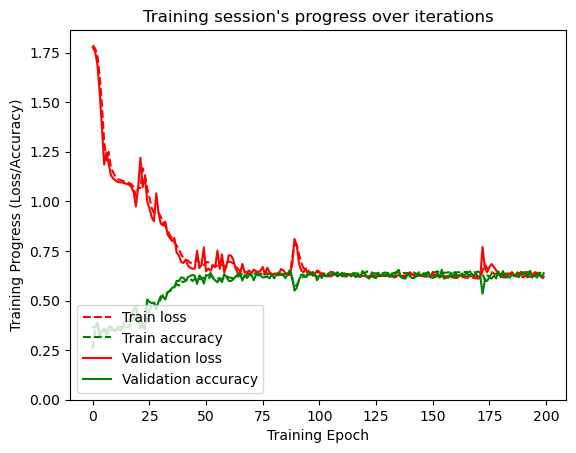

In [27]:
n_epochs = 200
batch_size = 1024 

history = model.fit(xtrain, ytrain, epochs = n_epochs, validation_split = 0.20, batch_size = batch_size, verbose = 1)

plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.show()